Apple Stock (AAPL) Machine Learning Binary Classification

In [147]:
#Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import plotly.express as px
import seaborn as sns

In [148]:
raw_df = yf.download('AAPL', start = '2010-01-01', end = '2025-07-26')
df = raw_df.copy() 

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_93423/1667098571.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [149]:
raw_df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431896,6.446622,6.382907,6.414464,493729600
2010-01-05,6.443017,6.479383,6.409055,6.449629,601904800
2010-01-06,6.340531,6.468562,6.333919,6.443016,552160000
2010-01-07,6.328810,6.371487,6.282827,6.363974,477131200
2010-01-08,6.370886,6.371488,6.283129,6.320395,447610800


In [150]:
df.columns = df.columns.droplevel(1)

In [151]:
df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.431896,6.446622,6.382907,6.414464,493729600
2010-01-05,6.443017,6.479383,6.409055,6.449629,601904800
2010-01-06,6.340531,6.468562,6.333919,6.443016,552160000
2010-01-07,6.328810,6.371487,6.282827,6.363974,477131200
2010-01-08,6.370886,6.371488,6.283129,6.320395,447610800


In [152]:
df = df.reset_index()
df = df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]

In [153]:
df.head()

Price,Date,Close,Open,High,Low,Volume
0,2010-01-04,6.431896,6.414464,6.446622,6.382907,493729600
1,2010-01-05,6.443017,6.449629,6.479383,6.409055,601904800
2,2010-01-06,6.340531,6.443016,6.468562,6.333919,552160000
3,2010-01-07,6.328810,6.363974,6.371487,6.282827,477131200
4,2010-01-08,6.370886,6.320395,6.371488,6.283129,447610800


In [154]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df = df.dropna()
df.head()

Price,Date,Close,Open,High,Low,Volume,Target
0,2010-01-04,6.431896,6.414464,6.446622,6.382907,493729600,1
1,2010-01-05,6.443017,6.449629,6.479383,6.409055,601904800,0
2,2010-01-06,6.340531,6.443016,6.468562,6.333919,552160000,0
3,2010-01-07,6.328810,6.363974,6.371487,6.282827,477131200,1
4,2010-01-08,6.370886,6.320395,6.371488,6.283129,447610800,0


In [155]:
#1-day return to capture the momentum of the stock
df['Return_1d'] = df['Close'].pct_change()

In [156]:
#5-day return
df['Return_5d'] = df['Close'].pct_change(5)
#2 and 3 day returns
df['Return_2d'] = df['Close'].pct_change(2)
df['Return_3d'] = df['Close'].pct_change(3)

In [157]:
#Moving averages for 10 days and 50 days, and their ratio
df['MA_10'] = df['Close'].rolling(10).mean()
df['MA_50'] = df['Close'].rolling(50).mean()
df['MA_ratio'] = df['MA_10'] / df['MA_50']

In [158]:
#5-day volatility (standard deviation of returns)
df['Volatility_5d'] = df['Return_1d'].rolling(5).std()

In [159]:
#Date-Based Features
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

In [160]:
#Volume Ratio
df['Volume_MA'] = df['Volume'].rolling(10).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']

In [161]:
#Return within a single day
df['IntraDay_Return'] = (df['Close'] - df['Open']) / df['Open']

In [162]:
#Daily Range: How much the stock moved within a day
df['Daily_Range'] = (df['High'] - df['Low']) / df['Close']

In [163]:
df.columns

Index(['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Target', 'Return_1d',
       'Return_5d', 'Return_2d', 'Return_3d', 'MA_10', 'MA_50', 'MA_ratio',
       'Volatility_5d', 'DayOfWeek', 'Month', 'Week', 'Volume_MA',
       'Volume_Ratio', 'IntraDay_Return', 'Daily_Range'],
      dtype='object', name='Price')

In [164]:
fig = px.line(df, x = 'Date', y = 'Close', title = 'Apple Stock (AAPL) Close Price (2010–2025)')
fig.update_xaxes(title_text = "Date")
fig.update_yaxes(title_text = "Adjusted Close Price (USD)")
fig.show()

In [165]:
stock_df = df[['Target', 
               'Return_1d', 'Return_2d', 'Return_3d',
               'Return_5d', 'MA_ratio', 'Volatility_5d',
               'Volume_Ratio', 'IntraDay_Return', 'Daily_Range',
               'DayOfWeek', 'Month', 'Week']].dropna()

In [166]:
stock_df.head()

Price,Target,Return_1d,Return_2d,Return_3d,Return_5d,MA_ratio,Volatility_5d,Volume_Ratio,IntraDay_Return,Daily_Range,DayOfWeek,Month,Week
49,0,0.002725,-0.009488,-0.004656,0.006412,1.066074,0.007847,0.835886,0.001204,0.011005,1,3,11
50,1,-0.001470,0.001251,-0.010944,-0.003202,1.072173,0.006863,0.831192,-0.003468,0.014189,2,3,11
51,0,0.002365,0.000891,0.003619,-0.003770,1.077834,0.006794,0.633362,0.002454,0.010639,3,3,11
52,1,-0.010683,-0.008344,-0.009802,-0.019197,1.078252,0.007134,1.105337,-0.011299,0.018043,4,3,11
53,1,0.011249,0.000445,0.002811,0.004066,1.079510,0.007943,0.897079,0.019413,0.026029,0,3,12


In [167]:
stock_df.shape

(3865, 13)

In [168]:
stock_df = stock_df.reset_index(drop = True)

In [169]:
px.histogram(stock_df, x = 'Return_1d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [170]:
px.histogram(stock_df, x = 'Return_2d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [171]:
px.histogram(stock_df, x = 'Return_3d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [172]:
px.histogram(stock_df, x = 'Return_5d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [173]:
px.histogram(stock_df, x = 'MA_ratio', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [174]:
px.histogram(stock_df, x = 'Volatility_5d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [175]:
px.histogram(stock_df, x = 'Volume_Ratio', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [176]:
px.histogram(stock_df, x = 'IntraDay_Return', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [177]:
px.histogram(stock_df, x = 'Daily_Range', color = 'Target', color_discrete_sequence = ['red', 'blue'])

<Axes: xlabel='Target', ylabel='count'>

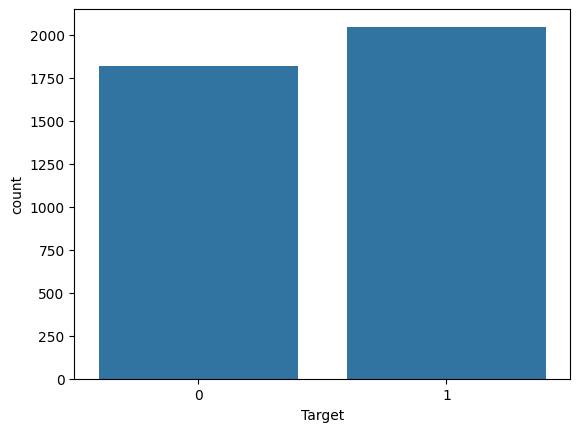

In [178]:
sns.countplot(data = stock_df, x = 'Target')

<Axes: xlabel='Target', ylabel='Daily_Range'>

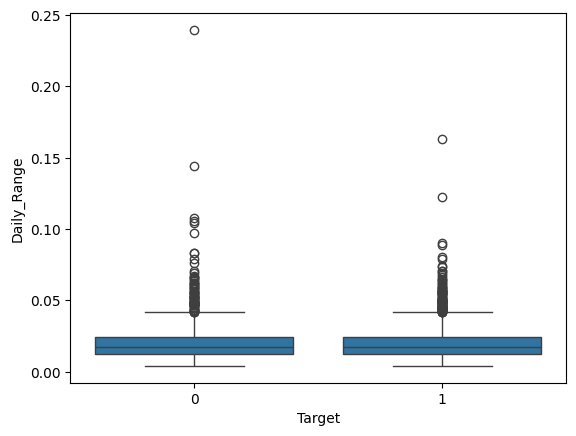

In [179]:
sns.boxplot(data = stock_df, x = 'Target', y = 'Daily_Range')

In [180]:
px.scatter(stock_df, x = 'Return_1d', y = 'Volatility_5d', color = stock_df['Target'].astype(str), color_discrete_sequence = ['red', 'blue'])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

divide by zero encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

overflow encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

invalid value encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

divide by zero encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

overflow encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

invalid value encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.

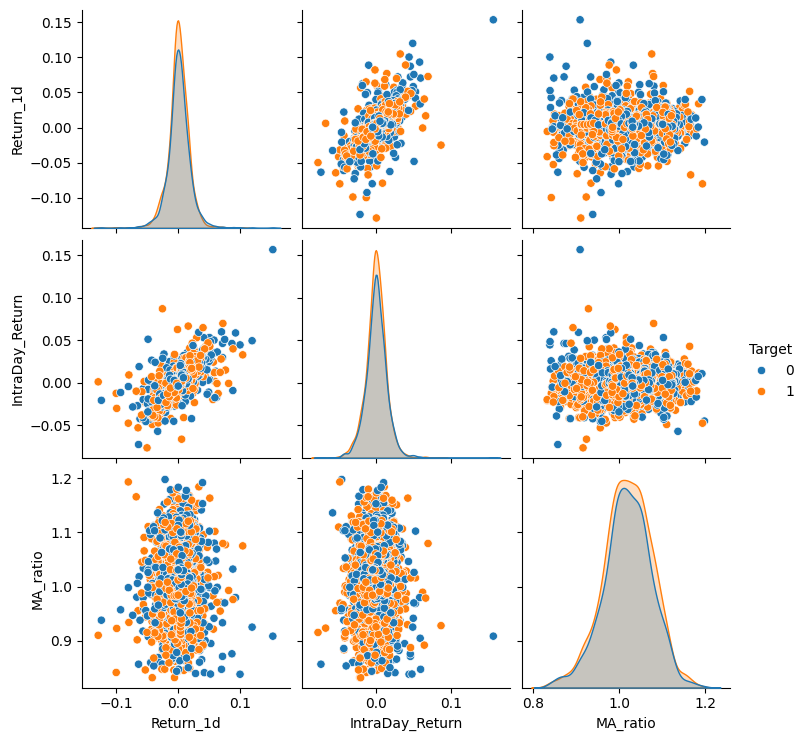

In [181]:
sns.pairplot(stock_df[['Return_1d', 'IntraDay_Return', 'MA_ratio', 'Target']], hue = 'Target')

In [182]:
numerical_columns = ['Return_1d', 'Return_2d', 'Return_3d', 'Return_5d',
                     'MA_ratio', 'Volatility_5d', 'Volume_Ratio',
                     'IntraDay_Return', 'Daily_Range']
categorical_columns = ['DayOfWeek', 'Month', 'Week']
X_inputs = stock_df[numerical_columns + categorical_columns]
Y_targets = stock_df['Target']

In [183]:
X_train, X_test, y_train, y_test = train_test_split(
    X_inputs, Y_targets, test_size = 0.2, shuffle = False
)

In [184]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3092, 12), (773, 12), (3092,), (773,))

In [186]:
#Preprocessing with OneHotEncoding and MinMaxScaling (-1, 1)
preprocessor = ColumnTransformer(
    transformers = [
        ('numerical', MinMaxScaler(feature_range = (-1, 1)), numerical_columns),
        ('categorical', OneHotEncoder(drop = None), categorical_columns)
    ]
)

In [187]:
#Model pipeline -> Preproccessing + Logistic Regression
model = Pipeline(
    steps = [
        ('preprocess', preprocessor),
        ('classifier', LogisticRegression(max_iter = 1000))
    ]
)

In [188]:
#FIt the model using training data
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [189]:
X_train

Price,Return_1d,Return_2d,Return_3d,Return_5d,MA_ratio,Volatility_5d,Volume_Ratio,IntraDay_Return,Daily_Range,DayOfWeek,Month,Week
0,0.002725,-0.009488,-0.004656,0.006412,1.066074,0.007847,0.835886,0.001204,0.011005,1,3,11
1,-0.001470,0.001251,-0.010944,-0.003202,1.072173,0.006863,0.831192,-0.003468,0.014189,2,3,11
2,0.002365,0.000891,0.003619,-0.003770,1.077834,0.006794,0.633362,0.002454,0.010639,3,3,11
3,-0.010683,-0.008344,-0.009802,-0.019197,1.078252,0.007134,1.105337,-0.011299,0.018043,4,3,11
4,0.011249,0.000445,0.002811,0.004066,1.079510,0.007943,0.897079,0.019413,0.026029,0,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...
3087,0.011534,-0.028575,-0.009039,-0.040618,0.913278,0.028749,1.502288,0.011455,0.024856,4,6,24
3088,0.032760,0.044672,0.003249,0.030254,0.910831,0.027523,0.895193,0.018363,0.027526,1,6,25
3089,-0.003827,0.028808,0.040674,0.019509,0.906118,0.027884,0.806305,0.004155,0.028445,2,6,25
3090,0.021574,0.017664,0.051003,0.020971,0.902940,0.028100,0.779761,0.010598,0.021407,3,6,25
